## Tom Segal's Digit Recognizer Submission

In this notebook I solve the CNN NMIST digit recognizer classifier by using Tensor Flow.

I try several different methods and compare between them with detailed documentation.

This exercise includes using Convulated Neural Networks (CNNs) to perform 2D image recognition, data augmentation and more. 

The Challenge page on kaggle.com 
https://www.kaggle.com/c/digit-recognizer/overview

This notebook relies on the following other notebooks:

https://www.kaggle.com/archaeocharlie/a-beginner-s-approach-to-classification

https://www.kaggle.com/toregil/welcome-to-deep-learning-cnn-99

https://www.kaggle.com/poonaml/deep-neural-network-keras-way



## import ##

In [58]:
import pandas as pd # used for reading and manipulating the data
import seaborn as sns # used for plotting
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical # to_categorical converts vectors to "1-hot" vectors
from sklearn.model_selection import train_test_split
from sklearn import svm
import numpy as np
from keras.optimizers import Adam, RMSprop
from keras.losses import categorical_crossentropy
from keras.models import Sequential # used to define the ML model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Lambda, Flatten, Dense, Conv2D, MaxPool2D, Dropout
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from sklearn.metrics import confusion_matrix



## define parameters ##

In [22]:
dataToUse = 5000 # how much data out of the dataset do we want to use? theres 42,000 in total.
totalData = 42000
imageDimensions = [28,28]

## load the data ##

In [23]:
# store the paths to the train and test datasets. Using the kaggle notebook these are available 
# via the "Data" tab at the top right corner of the interface.
datasetTrainPath = "../input/digit-recognizer/train.csv"
datasetTestPath = "../input/digit-recognizer/test.csv"
#datasetTrain = pd.read_csv(datasetTrainPath, nrows = dataToUse)
#datasetTest = pd.read_csv(datasetTestPath, nrows = dataToUse)
datasetTrain = pd.read_csv(datasetTrainPath)
datasetTest = pd.read_csv(datasetTestPath)

## observe the data and look for difficulties ##

In [24]:
datasetTrain.head(5) ## look at the first few items of each dataset

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
datasetTest.head(5)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## check data for difficulties ##

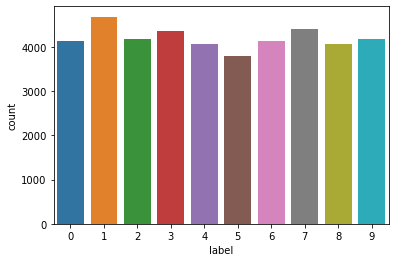

In [26]:
# split the train data into x and y, in this case digit image and digit label, respectiely.
datasetTrainY = datasetTrain["label"]
datasetTrainX = datasetTrain.drop(labels = ["label"] , axis = 1)
# the test data can't be split as it is unlabeled and contains "only x".
# check data for uniformity
labelDistributionPlot = sns.countplot(datasetTrainY)

we see that the data is more or less uniform, theres a more or less equal representation of the different digits.

check whether the datasets have any null values

In [27]:
datasetTrainX.isnull() # converts all non-null values to "False" and all null values to "True"

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
41996,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
41997,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
41998,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [28]:
datasetTrainX.isnull().any() # returns True or False in case there are / there aren't any null values for every column

pixel0      False
pixel1      False
pixel2      False
pixel3      False
pixel4      False
            ...  
pixel779    False
pixel780    False
pixel781    False
pixel782    False
pixel783    False
Length: 784, dtype: bool

In [29]:
datasetTrainX.isnull().any().describe() # describes the results in a more human-readable manner

count       784
unique        1
top       False
freq        784
dtype: object

we see that there are no null values for datasetTrainX.
Check the rest in an identical fashion.

In [30]:
datasetTrainY.head(5)

0    1
1    0
2    1
3    4
4    0
Name: label, dtype: int64

In [31]:
datasetTrainY.isnull().any() # for y we can't use "describe" because "any" already returns just one result because
# there is just one single column

False

In [32]:
datasetTest.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

## plot some of the data ##

the images are given as a 1-dimensional vector with 784 values which actually represents a 28x28 grayscale image.

to plot them they are reshaped into these dimensions.

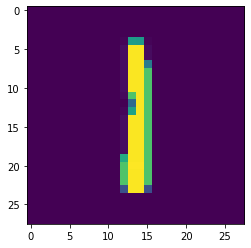

In [33]:
# values converts the first ([0]) datasetTrainX data into a numpy.ndarray
# reshape reshapes trainImageExample into a 28x28 grayscale image. the 1 is for grayscale (for RGB we would have 3)
# and the -1 is for the number of images, which is set to -1 in order to make the reshape function
# pick the correct number automatically based on the other dimensions chosen.
trainImageExample = datasetTrainX.values.reshape(-1,*imageDimensions,1)
# plot the whole width and height (":,:") of the third ([2]) train image ("0" is for the only (grayscale) channel)
datasetTrainPlot = plt.imshow(trainImageExample[2][:,:,0])

it is possible to plot multiple images using

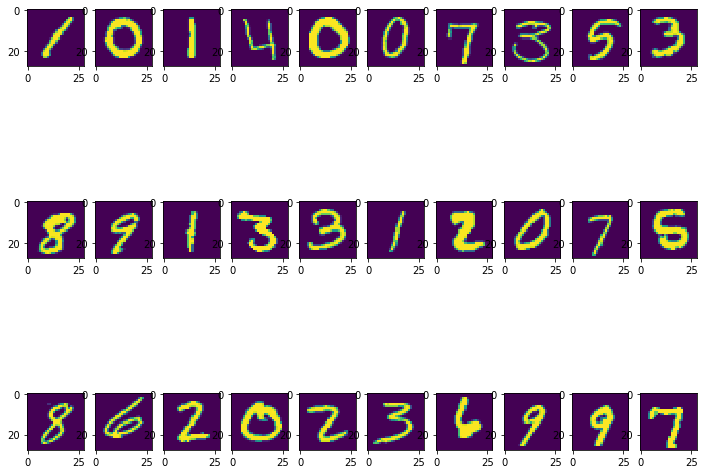

In [34]:
plt.figure(figsize=(12,10))
numToPlot = 30
for i in range(30):
    plt.subplot(3,10,i+1)
    plt.imshow(datasetTrainX.values[i].reshape(*imageDimensions), interpolation = "nearest")
plt.show()

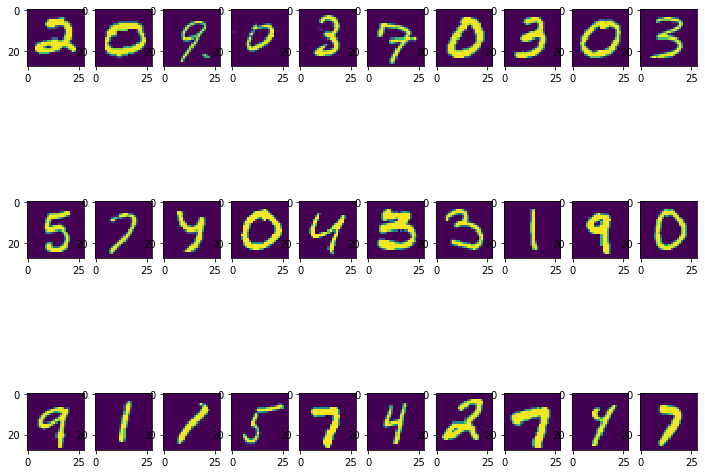

In [35]:
plt.figure(figsize=(12,10))
numToPlot = 30
for i in range(30):
    plt.subplot(3,10,i+1)
    plt.imshow(datasetTest.values[i].reshape(*imageDimensions), interpolation = "nearest")
plt.show()

## split the train dataset into train and validation datasets ##

it is important to have validation data in order to test our model on. The validation data is labeled, as opposed to the test data. However, we were not given validation data. Therefore we split the train data into train and validation.
This is the first time in the code that randomness comes into play. We define a randomness seed in order to make consequent runs more consistent.

In [36]:
# split 20% of the train data set into a validation data set in a random fashion.
# if the data was not evenly distributed we would have possibly needed
# to have used stratify = True in order to avoid unequally splitting the data
randomSeed = 0
datasetTrainX , datasetValX , datasetTrainY , datasetValY = train_test_split(datasetTrainX, datasetTrainY,
                                                                             test_size = 0.2, random_state = randomSeed)

## Method #1 - using a Support Vector Machine - SVM SVC & SVM LinearSVC ##

Support Vector Machines (SVM) and specifically SVC NuSVC and LinearSVC perform binary as well as multi classification on a dataset. They define a metric in which the dataset members are placed and divided into areas. The algorithm converges on the boundaries minimizing the loss function, such that the most dataset members are correctly clasified.

read about SVMs here https://scikit-learn.org/stable/modules/svm.html

 (cell set to markdown to increase running speed for higher samples, output noted below)

clf = svm.SVC() # use the default values C = 1, kernel = "rbf", degree = 3, gamma = "scale" and so on
clf.fit(datasetTrainX, datasetTrainY.ravel()) # ravel returns the flattened underlying data in the form of a ndarray
clf.score(datasetValX, datasetValY)

result: with 5000 samples 0.942 as in 94.2% of the validation images are correct. with 42000 samples 97.48%

try with a different kernel: (cell set to markdown to increase running speed for higher samples, output noted below)

clf = svm.SVC(kernel="linear")
clf.fit(datasetTrainX, datasetTrainY.ravel()) # ravel returns the flattened underlying data in the form of a ndarray
clf.score(datasetValX, datasetValY)


result with 5000 samples = 91%, worse than before. With 42000 samples took a long time to run. The documentation states the model is impractical for tens of thousands of examples and above, which is exactly what we see.

clf = svm.LinearSVC()
clf.fit(datasetTrainX, datasetTrainY.ravel()) # ravel returns the flattened underlying data in the form of a ndarray
clf.score(datasetValX, datasetValY)


result: 87.2% with 42000 data examples. Worse than SVC, at least with the default parameters.

## normalize the data ##

normalization is in general important as it speeds up the calculation.

Specifically for this dataset it has the added benefit of accounting for differences in brightness between the images.

In [37]:
# it is probably enough to either have .astype("float32") or the ".0" in order to convert the expression to a float
datasetTrainX = datasetTrainX.astype("float32") / 255.0
datasetValX = datasetValX.astype("float32") / 255.0

try again with normalized data

## continuing attempt #1 following normalization ##

clf = svm.SVC()
clf.fit(datasetTrainX, datasetTrainY.ravel()) # ravel returns the flattened underlying data in the form of a ndarray
clf.score(datasetValX, datasetValY)


result: 94.2%, same as before normalization.

## preparing the data in preparation for the next methods ##

encode the labels into "1-hot" vectors, which are 1d, 10-cells long vectors, with a "1" at the index representing the digit and "0" in the rest

In [38]:
datasetTrainY = to_categorical(datasetTrainY, num_classes = 10)
datasetValY = to_categorical(datasetValY, num_classes = 10)

In [39]:
# reshape the training data
# values converts datasetTrainX into a numpy.ndarray
# reshape datasetTrainX into a 28x28 grayscale image. the 1 is for grayscale (for RGB we would have 3)
# and the -1 is for the number of images, which is set to -1 in order to make the reshape function
# pick the correct number automatically based on the other dimensions chosen.
# instead of -1 we could have used datasetTrainX.shape[0] and datasetValX.shape[0]
datasetTrainX = datasetTrainX.values.reshape(-1,*imageDimensions,1)

# reshape the validation data
datasetValX = datasetValX.values.reshape(-1,*imageDimensions,1)



## Method #2 - Neural Network ##

In [40]:
#batch_size = int(64*(dataToUse/totalData))
# explanation on batch_size: with 42000 examples and 80% 20% split we have 42000 * 0.8 = 33600 train examples
# bath_size 64 means we will have 33600/64 = 525 batches.
# steps_per_epoch should in that case not be 33600 but 525 because each step is a batch.
# this is unlike whats done in https://www.kaggle.com/poonaml/deep-neural-network-keras-way/notebook
# where the number of steps is simply the number of train data examples. I don't understand why his notebook compiles.
# similarly validation_steps should not be genFlowVal.n but genFlowVal.n/batch_size
batch_size = 64

gen = ImageDataGenerator() # used for data augmentation, which we don't do for this model.
genFlowTrain = gen.flow(datasetTrainX, datasetTrainY, batch_size = batch_size)
genFlowVal = gen.flow(datasetValX, datasetValY, batch_size = batch_size)

In [41]:
datasetTrainXMean = datasetTrainX.mean().astype(np.float32)
datasetTrainXstd = datasetTrainX.std().astype(np.float32)

def standardize(x):
    return (x-datasetTrainXMean)/datasetTrainXstd

model = Sequential([
    Lambda(standardize, input_shape=(*imageDimensions,1)),
    Flatten(),
#    Dense(512, activation="relu"),
    Dense(10, activation="softmax")]) # 10 is the output size, softmax gives probability weights for each output

model.compile(optimizer = RMSprop(lr=0.001), loss = "categorical_crossentropy", metrics = ["accuracy"])
#model.compile(optimizer = Adam(lr=0.001), loss = "categorical_crossentropy", metrics = ["accuracy"])


print("the model's input shape is " + str(model.input_shape) + " and its output shape is " + str(model.output_shape))

the model's input shape is (None, 28, 28, 1) and its output shape is (None, 10)


In [42]:
epochs = 3
#steps_per_epoch = genFlowTrain.n # total number of examples in batchesTrain
steps_per_epoch = genFlowTrain.n // batch_size
validation_steps = genFlowVal.n // batch_size
#history = model.fit(datasetTrainX, datasetTrainY, batch_size = batch_size, epochs = epochs,
#                   validation_data = (datasetValX, datasetValY), verbose = 2)
history = model.fit_generator(generator = genFlowTrain, steps_per_epoch = steps_per_epoch,epochs = epochs,
                             validation_data = genFlowVal , validation_steps = validation_steps)

Epoch 1/3
525/525 [==============================] - 2s 4ms/step - loss: 0.4602 - accuracy: 0.8613 - val_loss: 0.3250 - val_accuracy: 0.9085
Epoch 2/3
525/525 [==============================] - 2s 4ms/step - loss: 0.3063 - accuracy: 0.9104 - val_loss: 0.3161 - val_accuracy: 0.9127
Epoch 3/3
525/525 [==============================] - 2s 4ms/step - loss: 0.2883 - accuracy: 0.9178 - val_loss: 0.3010 - val_accuracy: 0.9208


results:

RMSprop

3 epochs - loss: 0.2875 - accuracy: 0.9181 - val_loss: 0.2963 - val_accuracy: 0.9198
100 epochs - loss: 0.2096 - accuracy: 0.9422 - val_loss: 0.3530 - val_accuracy: 0.9173

Adam

3 epochs = loss: 0.1987 - accuracy: 0.9418 - val_loss: 0.3449 - val_accuracy: 0.9141

100 epochs - loss: 0.1988 - accuracy: 0.9418 - val_loss: 0.3469 - val_accuracy: 0.9141

plotting the loss

summary:

so far val_accuracy 0.942 with SVC and 0.9198 with a neural network using RMSProp, so that SVC performs better.

Text(0.5, 1.0, 'train (red) and validation (green) losses')

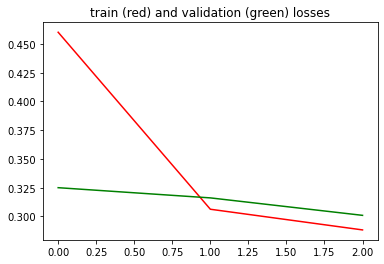

In [43]:
plt.plot(history.history["loss"], color = "r")
plt.plot(history.history["val_loss"], color = "g")
plt.title("train (red) and validation (green) losses")

plot the gain

Text(0.5, 1.0, 'train (red) and validation (green) accuracy')

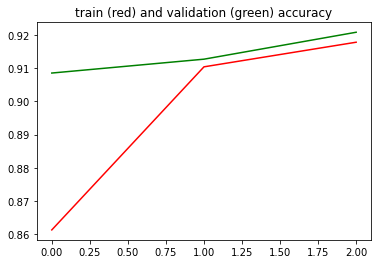

In [44]:
plt.plot(history.history["accuracy"], color = "r")
plt.plot(history.history["val_accuracy"], color = "g")
plt.title("train (red) and validation (green) accuracy")

plot results: the train losses and accuracy indeed go down and up respectively across many epochs, but the validation losses an accuracy stay about the same after the first few epochs. The graphs shows there is no need to perform more than 3-4-5 epochs, and that beyond 20 epochs the quality of the results even degrades due to overfitting.

## Method #3 - Deeper Neural Network ##

## define the model ##

before defining the actual model we will define the optimizer function which the model will use to adjust the different parameters of the neural network in order to minimize the loss function.

The optimizer is RMSprop with default values. It starts with a high learning rate and decreases it.

the loss function itself which we will use is "categorical_crossentropy" which is the difference between the calculated the actual labels.

In [45]:
optimizer = RMSprop(lr = 0.001, rho = 0.9, epsilon = 1e-8, decay = 0.0)

the model chosen is:
- a Conv2D layer with 32 filters with a kernel size of 5x5 which acts like a set of 5x5 filters using a relu activation function, which is a non-linear activation function.
- another identical Conv2D layer
- a MaxPool2D layer with a pool size of 2x2 which downsamples the image with a window of 2x2
- a Dropout layer with a proportionality factor of 0.25 which randomly ignores 25% of the nodes in each step, which reduces overfitting and enhances the connections between the nodes
- another set of 2 Conv2D, MaxPool2D and Dropout layers, but with 64 filters of 3x3 kernel size for the Conv2D which can possibly be thought of as more numerous, more precise filters for the pre-filtered and downsampled image, as well as strides of 2x2 for the MaxPool2D layer.
- a Flatten layer in order to convert the image back to 1D
- two dense layers with another Dropout 50% in-between.

In [47]:
model = Sequential()
# note the input_shape = (28,28,1) for the first Conv2D layer to account for the size of the input
model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = "relu", input_shape = (*imageDimensions,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = "Same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = "Same", activation = "relu"))
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = "Same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2), strides = (2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax")) # note "10" because thats the output size (number of digits)
# also note "softmax" which returns probabilities (weights) for each output (digit)

## compile the model ##

In [48]:
# note that the metrics used is accuracy, which is only used at the evaluation stage, not in the training stage.
model.compile(optimizer = RMSprop(), loss = categorical_crossentropy, metrics = ["accuracy"])

## run the model ##

In [49]:
epochs = 10
batch_size = 64

gen = ImageDataGenerator() # used for data augmentation, which we don't do for this model.
#gen.fit(datasetTrainX)
genFlowTrain = gen.flow(datasetTrainX, datasetTrainY, batch_size = batch_size)
genFlowVal = gen.flow(datasetValX, datasetValY, batch_size = batch_size)
steps_per_epoch = genFlowTrain.n // batch_size # // performs rounded-down division to int
validation_steps = genFlowVal.n // batch_size 
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

history = model.fit_generator(generator = genFlowTrain, steps_per_epoch = steps_per_epoch, epochs = epochs,
                             validation_data = genFlowVal, validation_steps = validation_steps,
                             )

Epoch 1/10
525/525 [==============================] - 111s 212ms/step - loss: 0.2293 - accuracy: 0.9267 - val_loss: 0.0623 - val_accuracy: 0.9807
Epoch 2/10
525/525 [==============================] - 110s 210ms/step - loss: 0.0762 - accuracy: 0.9770 - val_loss: 0.0401 - val_accuracy: 0.9877
Epoch 3/10
525/525 [==============================] - 109s 209ms/step - loss: 0.0550 - accuracy: 0.9843 - val_loss: 0.0365 - val_accuracy: 0.9884
Epoch 4/10
525/525 [==============================] - 110s 209ms/step - loss: 0.0456 - accuracy: 0.9861 - val_loss: 0.0356 - val_accuracy: 0.9907
Epoch 5/10
525/525 [==============================] - 109s 208ms/step - loss: 0.0421 - accuracy: 0.9877 - val_loss: 0.0393 - val_accuracy: 0.9897
Epoch 6/10
525/525 [==============================] - 110s 209ms/step - loss: 0.0380 - accuracy: 0.9892 - val_loss: 0.0344 - val_accuracy: 0.9907
Epoch 7/10
525/525 [==============================] - 114s 217ms/step - loss: 0.0344 - accuracy: 0.9903 - val_loss: 0.0335 -

results loss: 0.0284 - accuracy: 0.9911 - val_loss: 0.0283 - val_accuracy: 0.9914

plot the results

[]

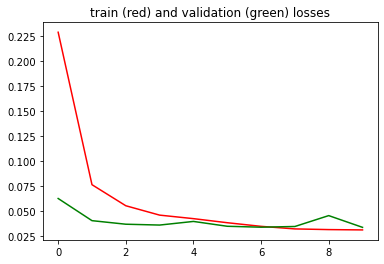

In [50]:
plt.plot(history.history["loss"], color = "r")
plt.plot(history.history["val_loss"], color = "g")
plt.title("train (red) and validation (green) losses")
plt.plot()

[]

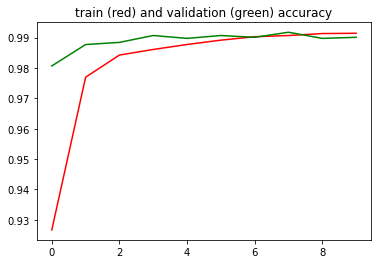

In [51]:
plt.plot(history.history["accuracy"], color = "r")
plt.plot(history.history["val_accuracy"], color = "g")
plt.title("train (red) and validation (green) accuracy")
plt.plot()

## results ##

SVC: SVC 0.942

shallow neural network: 0.9198

deep neural network: 0.9914

an accuracy of >99% was reached for the validation data using just 10 epochs and without data augmentation.

## Method #4 - Same Deep Neural Network With Data Augmentation ##

redefine gen to include:
- random zooming +-15%
- random shifts in height +-15%
- random shifts in width +-15%
- random rotations +- 15 degrees

In [52]:
gen = ImageDataGenerator(zoom_range = 0.15, height_shift_range = 0.15, width_shift_range = 0.15, rotation_range = 15)
genFlowTrain = gen.flow(datasetTrainX, datasetTrainY, batch_size = batch_size)
genFlowVal = gen.flow(datasetValX, datasetValY, batch_size = batch_size)

in addition to augmentation we use a changing learning rate.

In [53]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)


run the model again

In [54]:
epochs = 30
# use just a subset of the validation data in order to speed up the calculation. We will use the rest of it later.
validationDataSample = (datasetValX[:500,:], datasetValY[:500,:])
history2 = model.fit_generator(generator = genFlowTrain, steps_per_epoch = steps_per_epoch, epochs = epochs,
                             validation_data = validationDataSample, validation_steps = validation_steps,
                               callbacks = [annealer]
                             )

Epoch 1/30
525/525 [==============================] - 114s 217ms/step - loss: 0.2847 - accuracy: 0.9154 - val_loss: 0.0297 - val_accuracy: 0.9880
Epoch 2/30
525/525 [==============================] - 110s 210ms/step - loss: 0.1406 - accuracy: 0.9587
Epoch 3/30
525/525 [==============================] - 108s 207ms/step - loss: 0.1209 - accuracy: 0.9651
Epoch 4/30
525/525 [==============================] - 109s 207ms/step - loss: 0.1050 - accuracy: 0.9707
Epoch 5/30
525/525 [==============================] - 108s 205ms/step - loss: 0.0905 - accuracy: 0.9742
Epoch 6/30
525/525 [==============================] - 108s 207ms/step - loss: 0.0856 - accuracy: 0.9754
Epoch 7/30
525/525 [==============================] - 109s 207ms/step - loss: 0.0811 - accuracy: 0.9765
Epoch 8/30
525/525 [==============================] - 108s 207ms/step - loss: 0.0775 - accuracy: 0.9777
Epoch 9/30
525/525 [==============================] - 110s 210ms/step - loss: 0.0735 - accuracy: 0.9787
Epoch 10/30
525/525 [=

loss: 0.0964 - accuracy: 0.9741

now calculate the results for the entire validation set

In [60]:
final_val_loss, final_val_acc = model.evaluate(datasetValX, datasetValY, verbose=0)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_val_loss, final_val_acc))

Final loss: 0.0297, final accuracy: 0.9925


results loss: 0.0964 - accuracy: 0.9741 - val_loss: 0.0297, val_accuracy: 0.9925



plot the results

[]

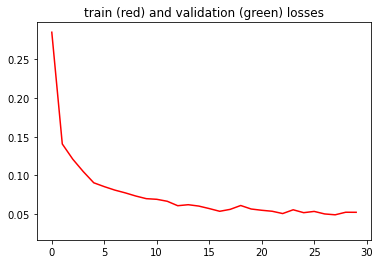

In [55]:
plt.plot(history2.history["loss"], color = "r")
plt.plot(history2.history["val_loss"], color = "g")
plt.title("train (red) and validation (green) losses")
plt.plot()

[]

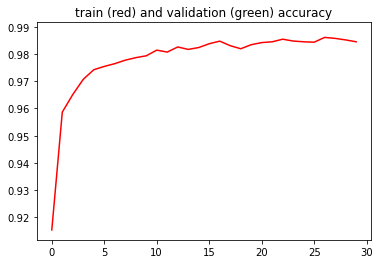

In [56]:
plt.plot(history2.history["accuracy"], color = "r")
plt.plot(history2.history["val_accuracy"], color = "g")
plt.title("train (red) and validation (green) accuracy")
plt.plot()

## confusion matrix ##

In [59]:
predictionsProbabilities = model.predict(datasetValX)
predictions = np.argmax(predictionsProbabilities, axis = 1)
actualLabels = np.argmax(datasetValY, axis = 1)
cm = confusion_matrix(actualLabels,predictions)
print(cm)


[[810   0   1   0   0   0   1   0   1   0]
 [  1 946   5   1   0   0   2   5   0   1]
 [  0   0 858   0   0   0   1   1   0   0]
 [  1   0   1 860   0   0   0   1   0   0]
 [  0   2   0   0 822   0   1   0   0   2]
 [  0   0   0   2   0 751   1   1   1   0]
 [  0   0   0   0   2   0 838   0   1   0]
 [  0   0   7   0   0   0   0 892   0   0]
 [  0   0   2   1   0   1   1   0 762   1]
 [  1   0   0   0   6   1   0   2   4 798]]


## predict the results for the test dataset ##

In [61]:
datasetTestArray = np.array(datasetTest)
datasetTestArray = datasetTestArray.reshape(-1,28,28,1)
predictions = model.predict(datasetTestArray)
print(predictions)
predictionsTest = []
for prediction in predictions:
    predictionsTest.append(np.argmax(prediction))

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


## submit the results ##

In [62]:
# create a new data structure with our predicted image labels
submission = pd.DataFrame({
    "ImageId" : datasetTest.index+1,
    "Label": predictionsTest
})
# convert it to a csv and save
submission.to_csv('submission.csv', index = False)

## summary ##

best results obtained using a deep convulated  neural network (CNN) with augmentation

results loss: 0.0964 - accuracy: 0.9741 - val_loss: 0.0297, val_accuracy: 0.9925